The purpose of this is to train a CNN model on the RAVDESS dataset, with baseline, data augmentation, speaker split and speaker split + augmentation. 

In [628]:
#imports
#%pip install matplotlib pandas numpy librosa soundfile seaborn

import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
import librosa.display
import librosa
import soundfile
import os
import glob

import warnings; warnings.filterwarnings('ignore') #matplotlib and librosa display clash
from IPython.core.display import HTML 

To show an example of one of the utterances in the RAVDESS audio-only dataset (the 'Happy' utterance by Actor 01):

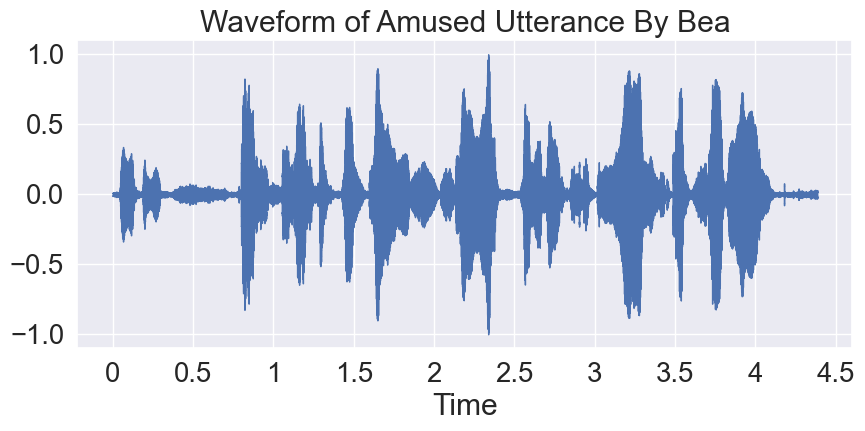

In [629]:
from matplotlib.colors import Normalize

with soundfile.SoundFile('EmoVDB/bea_Amused/amused_1-15_0001.wav') as audio:
    amused_waveform = audio.read(dtype='float32')
    sr = audio.samplerate
    plt.figure(figsize=(10,4))
    librosa.display.waveshow(amused_waveform, sr=sr)
    plt.title('Waveform of Amused Utterance By Bea')

Text(0.5, 1.0, 'Amused Power Spectrogram')

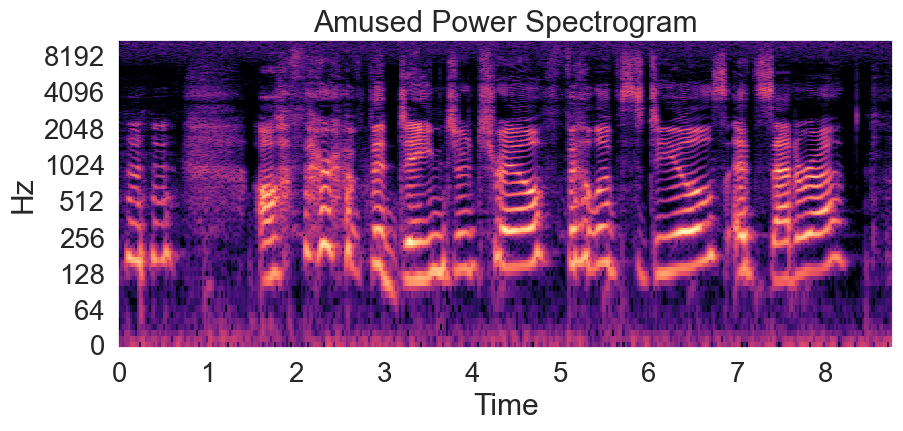

In [630]:
stft_amused = librosa.stft(amused_waveform)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_amused), ref=np.max), x_axis='time', y_axis='log')
plt.title('Amused Power Spectrogram')

Text(0.5, 1.0, 'Amused Mel Spectrogram')

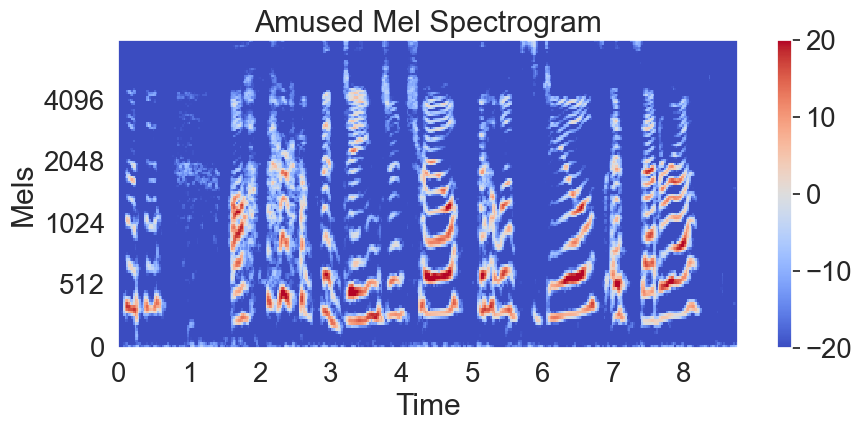

In [631]:
melspectrogram_amused = librosa.feature.melspectrogram(y=amused_waveform, sr=sr, n_mels=128, fmax=8000)
plt.figure(figsize=(10,4))
librosa.display.specshow(librosa.power_to_db(S=melspectrogram_amused, ref=np.mean), 
                         y_axis='mel', 
                         fmax=8000, 
                         x_axis='time',
                         norm=Normalize(vmin=-20,vmax=20))
plt.colorbar()
plt.ylabel('Mels')
plt.title('Amused Mel Spectrogram')

Text(0.5, 1.0, 'Amused MFC Coefficients')

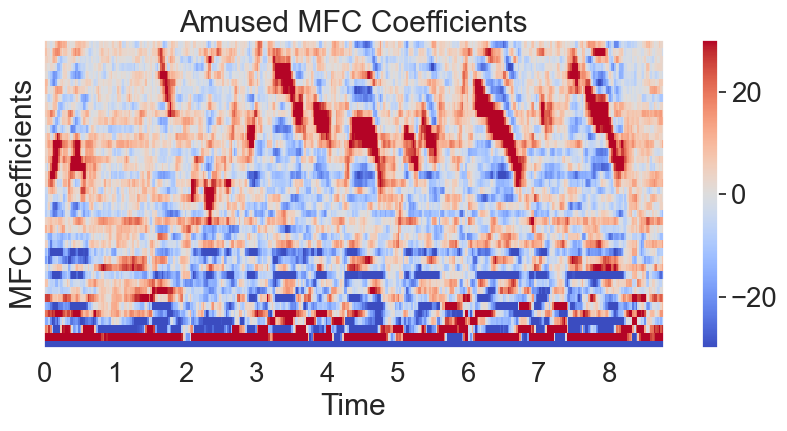

In [632]:
mfccs_amused = librosa.feature.mfcc(y=amused_waveform, sr=sr, n_mfcc=40)
plt.figure(figsize=(10,4))
librosa.display.specshow(mfccs_amused, x_axis='time', norm=Normalize(vmin=-30,vmax=30))
plt.colorbar()
plt.ylabel('MFC Coefficients')
plt.title('Amused MFC Coefficients')

Text(0.5, 1.0, 'Amused Chromagram')

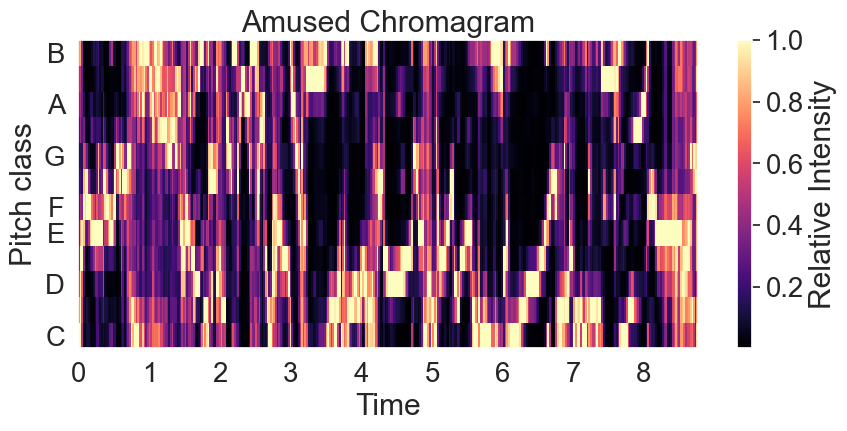

In [633]:
chromagram_amused = librosa.feature.chroma_stft(y=amused_waveform, sr=sr)
plt.figure(figsize=(10,4))
librosa.display.specshow(chromagram_amused, y_axis='chroma', x_axis='time')
plt.colorbar(label='Relative Intensity')
plt.title('Amused Chromagram')

Here we will do feature extraction:

Chromagram: Will produce 12 features; One for each of 12 pitch classes

Mel Spectrogram: Will produce 128 features

MFCC: Will produce 40 MFCCs

Spectral Contrast: Will produce 7 contrast values 

12+128+40+7 = 187

In [634]:
#### Helper functions for feature extraction ####

def feature_chromagram(signal, sample_rate):
    chromagram = np.mean(librosa.feature.chroma_stft(y=signal, sr=sample_rate).T, axis=0)
    return chromagram

def feature_melspectrogram(signal, sample_rate):
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfccs(signal, sample_rate):
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

def feature_spec_contrast(signal, sample_rate):
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sample_rate, n_bands=6).T, axis=0)
    return spec_contrast

def feature_zcr(signal):
    zcr = np.mean(librosa.feature.zero_crossing_rate(signal).T, axis=0)
    return zcr

In [635]:
def get_features(file):
    try:
        signal, sr = librosa.load(file, sr=16000, mono=True)

        if signal.size == 0 or np.all(signal == 0):
            print(f"Silent file: {file}")
            return None
        
        #zcr = feature_zcr(signal)
        chromagram = feature_chromagram(signal, sr)
        #melspectrogram = feature_melspectrogram(signal, sr)
        mfccs = feature_mfccs(signal, sr)
        spec_contrast = feature_spec_contrast(signal, sr)

        #sanity check
        #if chromagram.shape != (12,) or melspectrogram.shape != (128,) or mfccs.shape != (40,) or spec_contrast.shape != (7,):
            #print(f"Skipping {file}")
            #return None
        
        feature_matrix = np.hstack((#zcr.flatten(),
                                    chromagram.flatten(), 
                                    #melspectrogram.flatten(), 
                                    mfccs.flatten(),
                                    spec_contrast.flatten()
        ))

        return feature_matrix
    
    except Exception as e:
        print(f"Error processing {file}: {e}")
        return None

In [636]:
emotions_emoVDB = {
    'neutral': 0,
    'amused': 1,
    'anger': 2,
    'sleepiness': 3,
    'disgust': 4
}

label_map = {v: k for k, v in emotions_emoVDB.items()}

In [637]:
def load_data():
    X, y, valid_file_names = [], [], []
    count = 0
    for file in glob.glob('EmoVDB/**/*.wav', recursive=True):
        file_name = os.path.basename(file)
        emotion_code = file_name.split('_')[0].lower()
        emotion = emotions_emoVDB.get(emotion_code)
        
        if emotion is None:
            continue 

        features = get_features(file)
        if features is None:
            continue
            
        X.append(features)
        y.append(emotion)
        valid_file_names.append(file)
        count+=1
        print('\r' + f' Processed {count}/6893 audio samples.', end=' ')

    print(f'Finished loading dataset.')
    return np.array(X), np.array(y), np.array(valid_file_names, dtype=str)

In [638]:
features, emotions, file_names = load_data() 

 Processed 5906/6893 audio samples. Finished loading dataset.


Doing a check to see if everything is 1D here:

In [639]:
lengths = [len(f) for f in features]
print("Unique feature lengths:", set(lengths))

Unique feature lengths: {59}


Within the RAVDESS audio-only dataset, there is an uneven split of the eight emotions, with 'neutral' being half that of the other emotions. So when training the model on the dataset, the weights of the emotion classes should be considered.

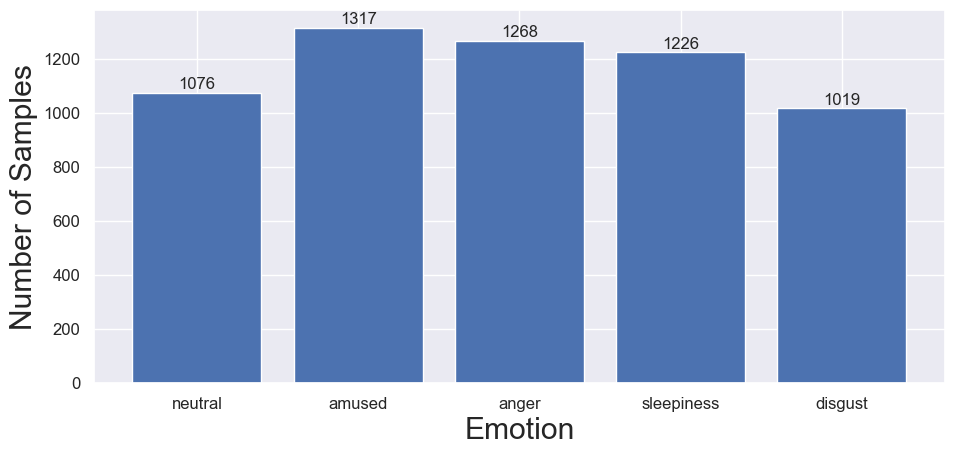

In [640]:
plt.figure(figsize=(10, 5))
emotion_labels, count = np.unique(emotions, return_counts=True)

sorted_indices = np.argsort(emotion_labels)
emotion_labels = emotion_labels[sorted_indices]
count = count[sorted_indices]

plt.bar(range(len(emotion_labels)), height=count)

for i, c in enumerate(count):
    plt.text(i, c + 2, str(c), ha='center', va='bottom', fontsize=12)

label_names = [label_map[label] for label in emotion_labels]

plt.xticks(ticks=range(len(emotion_labels)), labels=label_names, fontsize=12)
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

First, testing Support Vector Machine (SVM) on the dataset with and without speaker disjoint.
Data augmentation will be tested as well.

In [641]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features.copy())

encoder = LabelEncoder()
emotions_encoded = encoder.fit_transform(emotions)

##Unscaled train/test set##
X_train, X_test, y_train, y_test = train_test_split(
    features,
    emotions_encoded,
    test_size=0.2,
    random_state=70
)

##standard scaled test/train set##
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions_encoded,
    test_size=0.2,
    random_state=70
)

In [642]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

#### Set up the parameter grid for gridsearch cross-validation for SVM ####
param_grid_SVC = {
    'C': [1, 2, 3, 4, 5], 
    'gamma': ['scale', 0.01, 0.001, 0.0001], 
    'kernel': ['rbf']
}

gridSVC = GridSearchCV(
    SVC(class_weight='balanced',
        random_state=70), 
    param_grid_SVC, 
    cv=5, 
    verbose=1, 
    n_jobs=4
)

Firstly, testing on the dataset without speaker split between train and test:

In [643]:
gridSVC.fit(X_train_scaled, y_train)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_train_scaled, y_train)
test_accuracySVC = best_modelSVC.score(X_test_scaled, y_test)

print(f'==== Using SVM ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM ====
Training set accuracy with best parameters: 99.75%
Test set accuracy with best parameters: 97.63%


              precision    recall  f1-score   support

     neutral       0.97      0.99      0.98       229
      amused       0.98      0.96      0.97       252
       anger       0.99      0.98      0.98       247
  sleepiness       0.99      0.98      0.98       253
     disgust       0.96      0.98      0.97       201

    accuracy                           0.98      1182
   macro avg       0.98      0.98      0.98      1182
weighted avg       0.98      0.98      0.98      1182



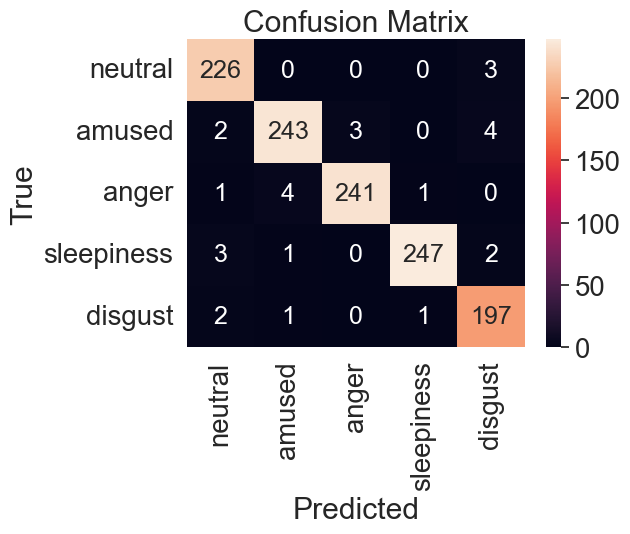

In [644]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_predSVC = best_modelSVC.predict(X_test_scaled)
print(classification_report(y_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_test

conf_matrix = confusion_matrix(y_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

t-SNE visualisation:

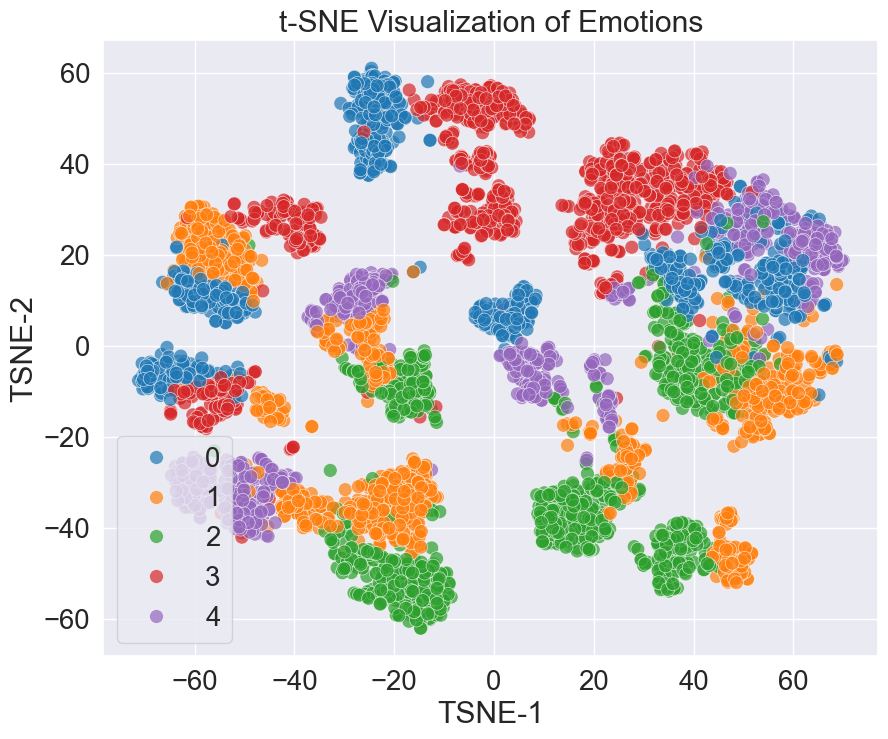

In [645]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=70)

X_tsne = tsne.fit_transform(X_train_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = y_train

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1',
                      y='TSNE-2',
                      hue='Emotion',
                      data=df_tsne,
                      palette='tab10',
                      s=100,
                      alpha=0.7,
                      edgecolor='w',
                      linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

In [646]:
#### Data augmentation helper functions ####

def add_white_noise(signal, noise_factor):
    '''
    Add white noise to the signal
    '''
    noise = np.random.normal(0, signal.std(), signal.size) 
    augmented_signal = signal + noise*noise_factor
    return augmented_signal

def time_stretch(signal, stretch_rate):
    '''
    Stretch the signal by a given stretch rate
    '''
    return librosa.effects.time_stretch(signal, rate=stretch_rate)

def pitch_scale(signal, sr, num_semitones):
    '''
    Scale the signal by a certain number of semitones
    '''
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=num_semitones)

def invert_polarity(signal):
    '''
    Invert the signal's polarity
    '''
    return signal*(-1)

def random_gain(signal, min_gain_factor, max_gain_factor):
    '''
    Add random gain to the signal
    '''
    gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
    return signal * gain_factor


In [647]:
def extract_features(signal, sr):
    #zcr = feature_zcr(signal)
    chromagram = feature_chromagram(signal, sr)
    #melspectrogram = feature_melspectrogram(signal, sr)
    mfccs = feature_mfccs(signal, sr)
    spec_contrast = feature_spec_contrast(signal, sr)

    #if chromagram.shape != (12,) or mfccs.shape != (40,) or spec_contrast.shape != (7,):
        #return None
    
    return np.hstack((#zcr.flatten(),
                      chromagram.flatten(),
                      #melspectrogram.flatten(),
                      mfccs.flatten(),
                      spec_contrast.flatten()
                      ))

def load_augmented_data():
    '''
    Return dataset augmented with:
        * White noise
        * Time stretch
        * Pitch scale
    '''
    X_aug, y_aug = [], []
    count = 0

    for file in glob.glob('EmoVDB/**/*.wav'):
        file_name = os.path.basename(file)
        emotion_code = file_name.split('_')[0].lower()
        emotion = emotions_emoVDB[emotion_code]

        signal, sr = librosa.load(file, sr=16000, mono=True)

        #### Augmentation of data ####
        #augment = np.random.choice(['noise', 'pitch'])

        #if augment == 'noise':
           #augmented = add_white_noise(signal, 0.01)
        #elif augment == 'pitch':
            #augmented = pitch_scale(signal, sr, 1)

        augmented = add_white_noise(signal, 0.01)
        augmented = pitch_scale(augmented, sr, 1)

        features = extract_features(augmented, sr)
        if features is None:
            continue

        X_aug.append(features)
        y_aug.append(emotion)

        count += 1
        print('\r' + f'Processed {count} files', end=' ')
    
    print('\nAugmentation done.')
    return np.array(X_aug), np.array(y_aug)

features_aug, emotions_aug = load_augmented_data()
features_total = np.vstack([features, features_aug])
emotions_total = np.hstack([emotions, emotions_aug])
print(f'Augmented data size: {features_total.shape}')


Processed 5906 files 
Augmentation done.
Augmented data size: (11812, 59)


Scaling and splitting the augmented data:

In [648]:
features_aug_scaled = scaler.fit_transform(features_aug.copy())

X_aug_train, X_aug_test, y_aug_train, y_aug_test = train_test_split(
    features_aug,
    emotions_aug,
    test_size = 0.2,
    random_state = 70
)

X_aug_train_scaled, X_aug_test_scaled, _, _ = train_test_split(
    features_aug_scaled,
    emotions_aug,
    test_size = 0.2,
    random_state = 70
)

In [649]:
gridSVC.fit(X_aug_train_scaled, y_aug_train)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_aug_train_scaled, y_aug_train)
test_accuracySVC = best_modelSVC.score(X_aug_test_scaled, y_aug_test)

print(f'==== Using SVM with data augmentation ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM with data augmentation ====
Training set accuracy with best parameters: 99.81%
Test set accuracy with best parameters: 97.63%


              precision    recall  f1-score   support

     neutral       0.96      0.99      0.97       229
      amused       0.95      0.97      0.96       252
       anger       1.00      0.97      0.98       247
  sleepiness       1.00      0.98      0.99       253
     disgust       0.97      0.98      0.97       201

    accuracy                           0.98      1182
   macro avg       0.98      0.98      0.98      1182
weighted avg       0.98      0.98      0.98      1182



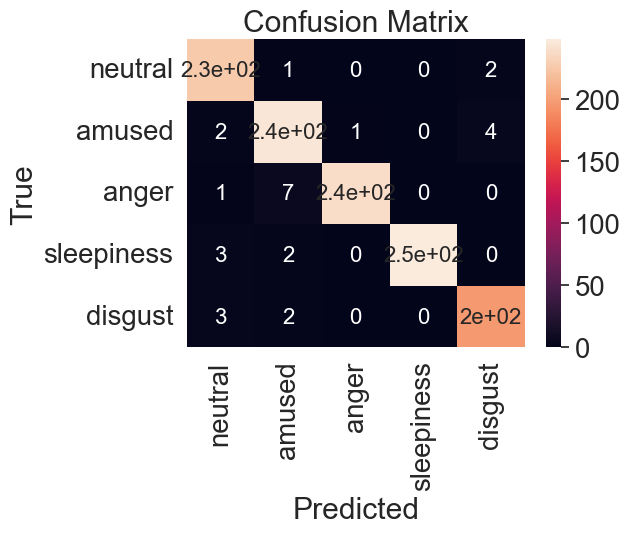

In [650]:
y_predSVC = best_modelSVC.predict(X_aug_test_scaled)
print(classification_report(
    y_aug_test,
    y_predSVC,
    target_names=[label_map[i] for i in sorted(label_map)]
))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_aug_test

conf_matrix = confusion_matrix(
    y_aug_test,
    y_predSVC,
    labels=sorted(label_map.keys())
)
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':16}
           #fmt='g'
           )
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

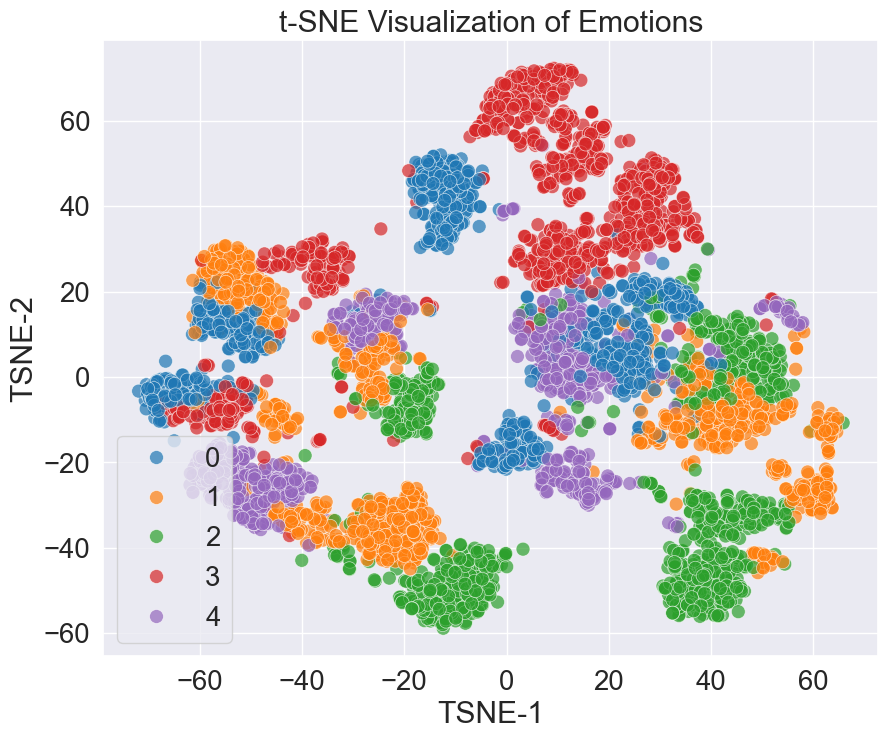

In [651]:
X_tsne = tsne.fit_transform(X_aug_train_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = y_aug_train

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1', y='TSNE-2', hue='Emotion', data=df_tsne, palette='tab10', s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

In [652]:
print(file_names[:5])

['EmoVDB/sam_Angry/anger_309-336_0311.wav'
 'EmoVDB/sam_Angry/anger_1-28_0005.wav'
 'EmoVDB/sam_Angry/anger_1-28_0011.wav'
 'EmoVDB/sam_Angry/anger_85-112_0111.wav'
 'EmoVDB/sam_Angry/anger_85-112_0105.wav']


Splitting the speakers so that the train and test do not overlap:

In [653]:
from sklearn.model_selection import GroupShuffleSplit

def extract_speaker(file_path):
    '''
    Extract the speaker IDs from the file names:
        "bea_Angry" -> "bea"
    '''
    folder = os.path.basename(os.path.dirname(file_path))
    speaker_id = folder.split('_')[0]
    return speaker_id

speaker_ids = np.array([extract_speaker(f) for f in file_names])

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=70)
train_idx, test_idx = next(gss.split(features, emotions, groups=speaker_ids))

X_disjoint_train, y_disjoint_train = features[train_idx], emotions[train_idx]
X_disjoint_test, y_disjoint_test = features[test_idx], emotions[test_idx]

train_speakers = sorted(set(speaker_ids[train_idx]))
test_speakers = sorted(set(speaker_ids[test_idx]))

overlapping_speakers = set(train_speakers).intersection(set(test_speakers))
assert len(overlapping_speakers) == 0, f"Overlap in speakers: {overlapping_speakers}"

#### Print Summary of Split ####
print(f'===== Speaker Disjoint Result ======\n')
print(f'Total sample number: {len(X_disjoint_train) + len(X_disjoint_test)}')
print(f'Train sample number: {len(X_disjoint_train)}')
print(f'Test sample number: {len(X_disjoint_test)}\n')

print(f'Train set speakers ({len(train_speakers)} in total):')
print(', '.join(sorted(train_speakers)).title())

print(f'\nTest set speakers ({len(test_speakers)} in total):')
print(', '.join(sorted(test_speakers)).title())

===== Speaker Disjoint Result ======

Total sample number: 5906
Train sample number: 4116
Test sample number: 1790

Train set speakers (3 in total):
Bea, Josh, Sam

Test set speakers (1 in total):
Jenie


In [654]:
#### Scaling ####
X_dj_train_scaled = scaler.fit_transform(X_disjoint_train.copy())
X_dj_test_scaled = scaler.transform(X_disjoint_test.copy())

In [655]:
gridSVC.fit(X_dj_train_scaled, y_disjoint_train)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_dj_train_scaled, y_disjoint_train)
test_accuracySVC = best_modelSVC.score(X_dj_test_scaled, y_disjoint_test)

print(f'==== Using SVM with speaker split ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM with speaker split ====
Training set accuracy with best parameters: 99.93%
Test set accuracy with best parameters: 60.73%


              precision    recall  f1-score   support

     neutral       0.59      0.05      0.08       417
      amused       0.39      0.71      0.50       222
       anger       0.83      0.92      0.87       496
  sleepiness       0.66      0.94      0.78       466
     disgust       0.10      0.07      0.09       189

    accuracy                           0.61      1790
   macro avg       0.51      0.54      0.46      1790
weighted avg       0.60      0.61      0.54      1790



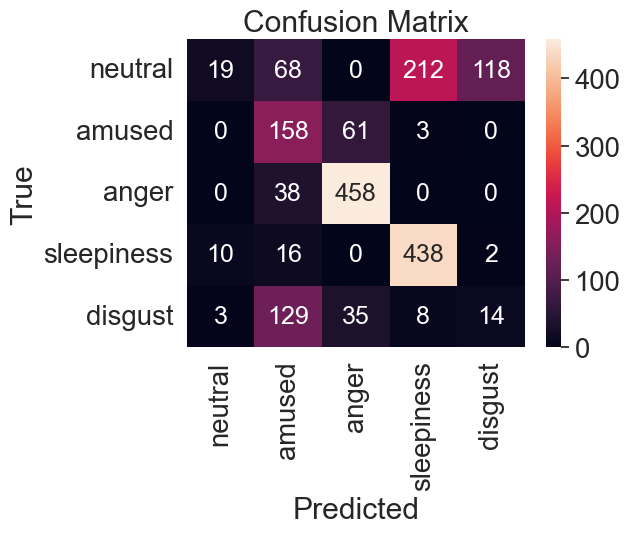

In [656]:
y_predSVC = best_modelSVC.predict(X_dj_test_scaled)
print(classification_report(y_disjoint_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_disjoint_test

conf_matrix = confusion_matrix(y_disjoint_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

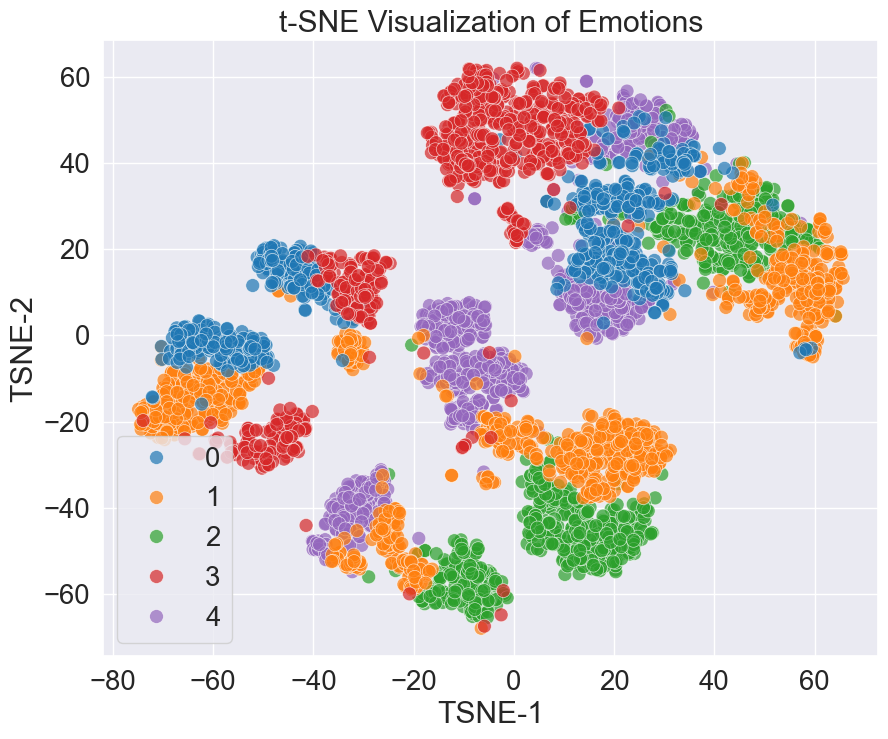

In [657]:
X_tsne = tsne.fit_transform(X_dj_train_scaled)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Emotion'] = y_disjoint_train

plt.figure(figsize=(10, 8))
plot = sn.scatterplot(x='TSNE-1', y='TSNE-2', hue='Emotion', data=df_tsne, palette='tab10', s=100, alpha=0.7, edgecolor='w', linewidth=0.5)
plot.legend(loc='lower left')
plt.title('t-SNE Visualization of Emotions')
plt.show()

In [658]:
train_file_paths = file_names[train_idx]
train_emotions = emotions[train_idx]

X_aug, y_aug = [], []

for path, label in zip(train_file_paths, train_emotions):
    signal, sr = librosa.load(path, sr=16000)

    ####Augmentations####
    for aug_signal in [
        add_white_noise(signal, 0.01),
        #time_stretch(signal, 0.97),
        pitch_scale(signal, sr, 1)
    ]:
        features_aug = extract_features(aug_signal, sr)
        if features_aug is not None:
            X_aug.append(features_aug)
            y_aug.append(label)
X_aug, y_aug = np.array(X_aug), np.array(y_aug)

print("Original data shape:", X_disjoint_train.shape)
print("Augmented data shape:", np.array(X_aug).shape)

#concatenate with original data 
X_disjoint_augmented = np.concatenate([X_disjoint_train, X_aug], axis=0)
y_disjoint_augmented = np.concatenate([y_disjoint_train, y_aug], axis=0)

print(f"\nAugmented training set size: {X_disjoint_augmented.shape[0]}")

Original data shape: (4116, 59)
Augmented data shape: (8232, 59)

Augmented training set size: 12348


In [659]:
#### Scaling ####
X_da_train_scaled = scaler.fit_transform(X_disjoint_augmented.copy())
X_da_test_scaled = scaler.transform(X_disjoint_test.copy())

In [660]:
gridSVC.fit(X_da_train_scaled, y_disjoint_augmented)
best_modelSVC = gridSVC.best_estimator_
training_accuracySVC = best_modelSVC.score(X_da_train_scaled, y_disjoint_augmented)
test_accuracySVC = best_modelSVC.score(X_da_test_scaled, y_disjoint_test)

print(f'==== Using SVM with speaker split ====')
print(f'Training set accuracy with best parameters: {100*training_accuracySVC:.2f}%')
print(f'Test set accuracy with best parameters: {100*test_accuracySVC:.2f}%')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
==== Using SVM with speaker split ====
Training set accuracy with best parameters: 99.99%
Test set accuracy with best parameters: 61.62%


              precision    recall  f1-score   support

     neutral       0.46      0.08      0.14       417
      amused       0.45      0.76      0.56       222
       anger       0.86      0.86      0.86       496
  sleepiness       0.61      0.97      0.75       466
     disgust       0.21      0.11      0.14       189

    accuracy                           0.62      1790
   macro avg       0.52      0.56      0.49      1790
weighted avg       0.58      0.62      0.55      1790



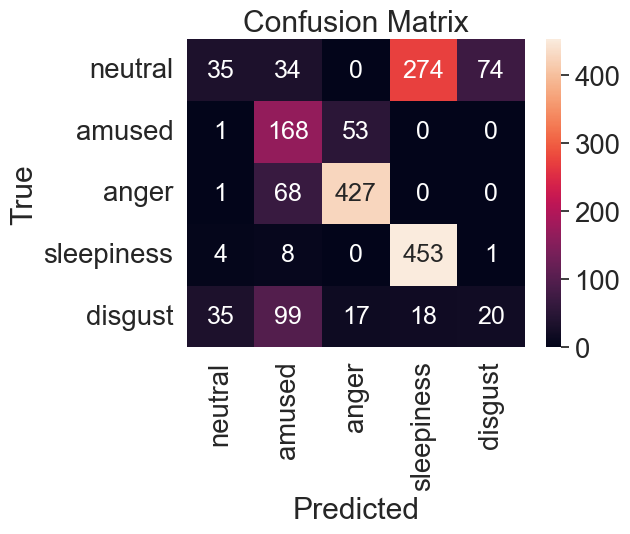

In [661]:
y_predSVC = best_modelSVC.predict(X_da_test_scaled)
print(classification_report(y_disjoint_test,
                            y_predSVC,
                            target_names=[label_map[i] for i in sorted(label_map)]
                            ))

test_emo_pred = y_predSVC
test_emo_groundtruth = y_disjoint_test

conf_matrix = confusion_matrix(y_disjoint_test, y_predSVC, labels=sorted(label_map.keys()))
confmatrix_df = pd.DataFrame(
    conf_matrix,
    index=[label_map[i] for i in sorted(label_map)],
    columns=[label_map[i] for i in sorted(label_map)]
)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.set_theme(font_scale=1.8)
sn.heatmap(confmatrix_df,
           annot=True,
           annot_kws={'size':18},
           fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Here we will do an experiment: training on EmoV-DB and testing on RAVDESS. Mapping of the emotional labels from one dataset to another is required. We will also be approximating and grouping some emotion labels, as RAVDESS has three more than EmoV-DB, and the two datasets have some differing labels as well.

In [662]:
#### Load data function for RAVDESS ####

emotionsRAVDESS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def load_data_RAVDESS():
    X, y, valid_file_names = [], [], []
    count = 0
    for file in glob.glob('RAVDESS/Actor_*/*.wav'):
        file_name = os.path.basename(file)
        emotion_code = file_name.split('-')[2]
        emotion = emotionsRAVDESS.get(emotion_code)
        
        if emotion is None:
            print(f"Emotion not found for {file_name} with code {emotion_code}")
            continue 
        
        features = get_features(file)
        if features is None:
            print(f"Failed to extract features for {file_name}")
            continue
            
        X.append(features)
        y.append(emotion)
        valid_file_names.append(file_name)
        count+=1
        print('\r' + f' Processed {count}/{1440} audio samples', end=' ')
    return np.array(X), np.array(y), np.array(valid_file_names)

featuresRD, emotionsRD, file_namesRD = load_data_RAVDESS()

 Processed 1440/1440 audio samples 

In [663]:
print(f"First few labels in emotionsRD: {emotionsRD[:10]}")

First few labels in emotionsRD: ['angry' 'fearful' 'fearful' 'angry' 'disgust' 'sad' 'sad' 'disgust'
 'surprised' 'surprised']


In [678]:
#### Emotion Label Mapping ####
'''
Here we will be using common labels for simpler mapping. The RAVDESS emotions will have to be filtered, first.
'''

valid_ravdess_labels = {'neutral', 'calm', 'happy', 'angry', 'disgust', 'sad'}
filtered_indices = [i for i, label in enumerate(emotionsRD) if label in valid_ravdess_labels]

X_ravdess = featuresRD[filtered_indices]
y_ravdess_str = [emotionsRD[i] for i in filtered_indices]

emotions_remap = {
    'calm': 'neutral',
    'happy': 'amused',
    'angry': 'anger',
    'disgust': 'disgust',
    'sad': 'sleepiness'
}
valid_ravdess_labels = set(emotions_remap.keys())

# Step 2: Apply filtering
filtered_indices = [i for i, label in enumerate(emotionsRD) if label in valid_ravdess_labels]
featuresRD_filtered = featuresRD[filtered_indices]
emotionsRD_filtered = [emotionsRD[i] for i in filtered_indices]

# Step 3: Remap string labels to integers
y_ravdess = np.array([emotions_emoVDB[emotions_remap[label]] for label in emotionsRD_filtered])

#### Scale Features ####
X_ravdess_scaled = scaler.transform(featuresRD_filtered)

#### Train and Predict ####
gridSVC.fit(X_train_scaled, y_train)
best_modelSVC = gridSVC.best_estimator_
y_predRD = best_modelSVC.predict(X_ravdess_scaled)

# Check and report
print(f"Length of y_ravdess (true): {len(y_ravdess)}")
print(f"Length of y_predRD (pred): {len(y_predRD)}")

if len(y_ravdess) != len(y_predRD):
    raise ValueError("Mismatch in number of samples between ground truth and predictions!")

print("\n==== Classification Report (Test on RAVDESS) ====")
shared_names = ['neutral', 'amused', 'anger', 'sleepiness', 'disgust']
print(classification_report(y_ravdess, y_predRD, target_names=shared_names))

print("\nBest parameters from EmoV-DB Grid Search:")
print(gridSVC.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Length of y_ravdess (true): 960
Length of y_predRD (pred): 960

==== Classification Report (Test on RAVDESS) ====
              precision    recall  f1-score   support

     neutral       0.58      0.11      0.18       192
      amused       0.10      0.09      0.10       192
       anger       0.25      0.97      0.39       192
  sleepiness       0.29      0.01      0.02       192
     disgust       0.00      0.00      0.00       192

    accuracy                           0.24       960
   macro avg       0.24      0.24      0.14       960
weighted avg       0.24      0.24      0.14       960


Best parameters from EmoV-DB Grid Search:
{'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [679]:
print("Unique emotions in filtered RAVDESS:", set([emotionsRD[i] for i in filtered_indices]))
print(f"Unique remapped labels in RAVDESS: {np.unique(y_ravdess)}")

Unique emotions in filtered RAVDESS: {np.str_('disgust'), np.str_('sad'), np.str_('angry'), np.str_('happy'), np.str_('calm')}
Unique remapped labels in RAVDESS: [0 1 2 3 4]


In [680]:
gridSVC.fit(X_ravdess_scaled, y_ravdess)
best_model = gridSVC.best_estimator_

# ========== Step 5: Predict on EmoV-DB ==========
y_pred_emovdb = best_model.predict(features_scaled)

# ========== Step 6: Report ==========
emotion_names = [label for label, idx in sorted(emotions_emoVDB.items(), key=lambda x: x[1])]

print("\n==== Classification Report (Test on EmoV-DB) ====")
print(classification_report(emotions, y_pred_emovdb, target_names=emotion_names))

print("\nBest parameters from RAVDESS Grid Search:")
print(gridSVC.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

==== Classification Report (Test on EmoV-DB) ====
              precision    recall  f1-score   support

     neutral       0.02      0.00      0.00      1076
      amused       0.40      0.53      0.46      1317
       anger       0.24      0.73      0.36      1268
  sleepiness       0.40      0.07      0.13      1226
     disgust       0.38      0.02      0.03      1019

    accuracy                           0.29      5906
   macro avg       0.29      0.27      0.20      5906
weighted avg       0.29      0.29      0.21      5906


Best parameters from RAVDESS Grid Search:
{'C': 5, 'gamma': 0.01, 'kernel': 'rbf'}


In [681]:
train_pred = best_model.predict(X_ravdess_scaled)
print("\nTraining Performance")
print(classification_report(y_ravdess, train_pred, target_names=emotion_names))


Training Performance
              precision    recall  f1-score   support

     neutral       0.92      0.99      0.95       192
      amused       0.98      0.93      0.96       192
       anger       0.98      0.97      0.97       192
  sleepiness       0.97      0.93      0.95       192
     disgust       0.95      0.96      0.96       192

    accuracy                           0.96       960
   macro avg       0.96      0.96      0.96       960
weighted avg       0.96      0.96      0.96       960

